In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'

def read_csv(root_path):
    with open(root_path + 'driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        for line in reader:
            yield line

def make_local_path(path, local_root):
    basename = path.split('/')[-1]
    return local_root + 'IMG/' + basename

def load_image(local_path):
    return cv2.imread(local_path)

def extract_images(csv_line, local_root):
    paths = csv_line[0:3]
    return [load_image(make_local_path(p, local_root)) for p in paths]

def extract_measurements(csv_line):
    return float(csv_line[3])

def read_data(path):
    images = []
    measurements = []
    
    for line in tqdm(read_csv(path)):
        images.append(extract_images(line, path)[0])
        measurements.append(extract_measurements(line))
        
    return (np.array(images, np.float32), np.array(measurements, np.float32))

In [2]:
data_path = './driving/'

images, measurements = read_data(data_path)
print("Image data: ", images.shape)
print("Measurement data: ", measurements.shape)

X_train = images
y_train = measurements

12767it [00:34, 369.35it/s]


Image data:  (12767, 160, 320, 3)
Measurement data:  (12767,)


In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Convolution2D, MaxPooling2D, Lambda, Cropping2D, Dropout

image_shape = X_train.shape[1:]
normalize = lambda x: (x - 127.0) / 127.0
cropping = ((60, 0), (0, 0))
dropout_rate = 0.3

model = Sequential()
model.add(Lambda(normalize, input_shape=image_shape))
model.add(Cropping2D(cropping=cropping))
model.add(Convolution2D(24, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(36, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(48, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Convolution2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))

model.add(Flatten())
model.add(Dropout(dropout_rate))
model.add(Dense(100, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(50, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, verbose=2, batch_size=256, epochs=20)

model.save('model.h5')

Train on 10213 samples, validate on 2554 samples
Epoch 1/20
16s - loss: 0.0939 - val_loss: 0.1814
Epoch 2/20
16s - loss: 0.0746 - val_loss: 0.1643
Epoch 3/20
16s - loss: 0.0686 - val_loss: 0.1529
Epoch 4/20
16s - loss: 0.0656 - val_loss: 0.1528
Epoch 5/20
16s - loss: 0.0631 - val_loss: 0.1835
Epoch 6/20
16s - loss: 0.0603 - val_loss: 0.1774
Epoch 7/20
16s - loss: 0.0586 - val_loss: 0.1590
Epoch 8/20
16s - loss: 0.0550 - val_loss: 0.1592
Epoch 9/20
16s - loss: 0.0547 - val_loss: 0.1605
Epoch 10/20
16s - loss: 0.0511 - val_loss: 0.1576
Epoch 11/20
16s - loss: 0.0485 - val_loss: 0.1767
Epoch 12/20
16s - loss: 0.0452 - val_loss: 0.1650
Epoch 13/20
16s - loss: 0.0423 - val_loss: 0.1787
Epoch 14/20
16s - loss: 0.0413 - val_loss: 0.1675
Epoch 15/20
16s - loss: 0.0360 - val_loss: 0.1978
Epoch 16/20
16s - loss: 0.0352 - val_loss: 0.1675
Epoch 17/20
16s - loss: 0.0330 - val_loss: 0.1840
Epoch 18/20
16s - loss: 0.0307 - val_loss: 0.1752
Epoch 19/20
16s - loss: 0.0308 - val_loss: 0.1841
Epoch 20/2

(0, 0.2)

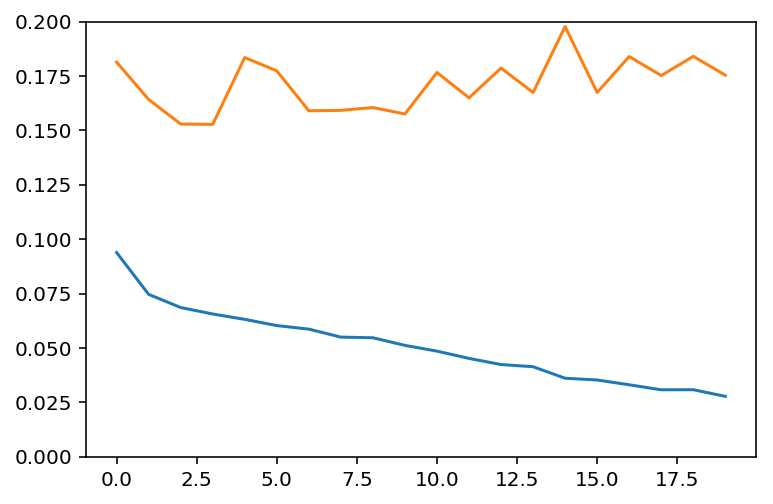

In [8]:
epochs = history.epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.ylim(0, 0.2)